<a href="https://colab.research.google.com/github/michaeledge27/CSCI290/blob/main/notebooks/partnerProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

In [2]:
url = "https://github.com/michaeledge27/CSCI290/raw/refs/heads/main/data/MBA.csv"
MBAdf = pd.read_csv(url)

In [3]:
MBAdf.head()

,application_id,gender,international,gpa,major,race,gmat,work_exp,work_industry,admission
0,1,Female,False,3.30,Business,Asian,620.0,3.0,Financial Services,Admit
1,2,Male,False,3.28,Humanities,Black,680.0,5.0,Investment Management,NaN
2,3,Female,True,3.30,Business,NaN,710.0,5.0,Technology,Admit
3,4,Male,False,3.47,STEM,Black,690.0,6.0,Technology,NaN
4,5,Male,False,3.35,STEM,Hispanic,590.0,5.0,Consulting,NaN


In [4]:
MBAdf['gmat'].nunique()

22

In [5]:
colsInUse = ['gender', 'international', 'gpa', 'major', 'race', 'gmat', 'work_exp', 'work_industry', 'admission']
mbadf = MBAdf[colsInUse]
mbadf.head()

,gender,international,gpa,major,race,gmat,work_exp,work_industry,admission
0,Female,False,3.30,Business,Asian,620.0,3.0,Financial Services,Admit
1,Male,False,3.28,Humanities,Black,680.0,5.0,Investment Management,NaN
2,Female,True,3.30,Business,NaN,710.0,5.0,Technology,Admit
3,Male,False,3.47,STEM,Black,690.0,6.0,Technology,NaN
4,Male,False,3.35,STEM,Hispanic,590.0,5.0,Consulting,NaN


In [6]:
mbadf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6194 entries, 0 to 6193
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         6194 non-null   object 
 1   international  6194 non-null   bool   
 2   gpa            6194 non-null   float64
 3   major          6194 non-null   object 
 4   race           4352 non-null   object 
 5   gmat           6194 non-null   float64
 6   work_exp       6194 non-null   float64
 7   work_industry  6194 non-null   object 
 8   admission      1000 non-null   object 
dtypes: bool(1), float64(3), object(5)
memory usage: 393.3+ KB


In [7]:
colsInUseNotTarget = ['gender', 'international', 'gpa', 'major', 'race', 'gmat', 'work_exp', 'work_industry']

# Categorical Selection Method

In [8]:
import numpy as np
import math

In [9]:
# Calculate the entropy for a categorical feature
def categorical_entropy(df, target, feature):
    entropyList = []  # List to store entropy values
    uniqueVals = df[feature].unique()  # Get unique values for the feature
    overall = len(df)  # Total number of rows
    for val in uniqueVals:
        entropy = 0  # Initialize entropy for each unique value
        subset_size = len(df[df[feature] == val])  # Size of subset for the current value
        weight = subset_size / overall  # Weight of the subset
        props = df[df[feature] == val][target].value_counts(normalize=True)  # Get the proportion of target values
        for p in props:
          entropy -= weight * (p * math.log2(p))  # Calculate entropy for the current value
          entropyList.append(entropy)  # Append entropy value to the list
    return min(entropyList)  # Return the minimum entropy value

In [10]:
# Calculate the Gini index for a categorical feature
def categorical_gini(df, target, feature):
    giniList = []  # List to store Gini values
    uniqueVals = df[feature].unique()  # Get unique values for the feature
    overall = len(df)  # Total number of rows
    for val in uniqueVals:
        subset_size = len(df[df[feature] == val])  # Size of subset for the current value
        weight = subset_size / overall  # Weight of the subset
        props = df[df[feature] == val][target].value_counts(normalize=True)  # Get the proportion of target values
        gini = 1 - np.sum(np.square(props))  # Calculate Gini for the current value
        giniList.append(weight * gini)  # Append weighted Gini value to the list
    return min(giniList)  # Return the minimum Gini value

In [11]:
# Calculate the entropy for a quantitative feature
def quantitative_entropy(df, target, feature):
    entropyList = []  # List to store entropy values
    splitPoints = []  # List to store split points
    uniqueVals = np.sort(df[feature].unique())  # Sorted unique values for the feature
    overall = len(df)  # Total number of rows
    for val in uniqueVals:
        entropy = 0  # Initialize entropy for each unique value
        # Split the data into two subsets: <= val and > val
        left = df[df[feature] <= val][[feature, target]]
        right = df[df[feature] > val][[feature, target]]

        # Calculate the entropy for the left subset
        props_left = left[target].value_counts(normalize=True)
        weight_left = len(left) / overall
        for prop in props_left:
            if prop > 0:
                entropy -= weight_left * prop * math.log2(prop)

        # Calculate the entropy for the right subset
        props_right = right[target].value_counts(normalize=True)
        weight_right = len(right) / overall
        for prop in props_right:
            if prop > 0:
                entropy -= weight_right * prop * math.log2(prop)

        entropyList.append(entropy)  # Append entropy value to the list
        splitPoints.append(val)  # Append split point to the list

    min_entropy = np.min(entropyList)  # Get the minimum entropy value
    best_split = splitPoints[np.argmin(entropyList)]  # Find the corresponding split point
    return min_entropy, best_split


In [12]:
# Calculate the Gini index for a quantitative feature
def quantitative_gini(df, target, feature):
    giniList = []  # List to store Gini values
    splitPoints = []  # List to store split points
    uniqueVals = np.sort(df[feature].unique())  # Sorted unique values for the feature
    overall = len(df)  # Total number of rows
    for val in uniqueVals:
        gini = 0  # Initialize Gini index for each unique value
        # Split the data into two subsets: <= val and > val
        left = df[df[feature] <= val][[feature, target]]
        right = df[df[feature] > val][[feature, target]]

        # Calculate the Gini for the left subset
        props_left = left[target].value_counts(normalize=True)
        weight_left = len(left) / overall
        gini_left = 1 - np.sum(np.square(props_left))

        # Calculate the Gini for the right subset
        props_right = right[target].value_counts(normalize=True)
        weight_right = len(right) / overall
        gini_right = 1 - np.sum(np.square(props_right))

        # Combine Gini values and append to the list
        gini = weight_left * gini_left + weight_right * gini_right
        giniList.append(gini)
        splitPoints.append(val)

    min_gini = np.min(giniList)  # Get the minimum Gini value
    best_split = splitPoints[np.argmin(giniList)]  # Find the corresponding split point
    return min_gini, best_split

In [13]:
# Helper function to check if a feature is categorical
def isCategorical(df, feature):
    return df[feature].nunique() < 8  # A feature is considered categorical if it has fewer than 8 unique values


In [14]:
# Main attribute selection method function
def classifcation_attribute_selection_method(df, target, measure):
    categoricalList = []  # Store results for categorical features
    categoricalFeatureList = []  # Store categorical feature names
    quantitativeList = []  # Store results for quantitative features
    quantitativeFeatureList = []  # Store quantitative feature names
    splitList = []  # Store best split points for quantitative features
    features = df.columns.drop(target)  # Get all features except the target

    for feature in features:
        if isCategorical(df, feature):  # If feature is categorical
            if measure == 'entropy':
                result = categorical_entropy(df, target, feature)
            elif measure == 'gini':
                result = categorical_gini(df, target, feature)
            categoricalList.append(result)
            categoricalFeatureList.append(feature)
        else:  # If feature is quantitative
            if measure == 'entropy':
                min_entropy, best_split = quantitative_entropy(df, target, feature)
                quantitativeList.append(min_entropy)
                splitList.append(best_split)
            elif measure == 'gini':
                min_gini, best_split = quantitative_gini(df, target, feature)
                quantitativeList.append(min_gini)
                splitList.append(best_split)
            quantitativeFeatureList.append(feature)

    # Determine the best feature and split point
    if categoricalList and min(categoricalList) <= min(quantitativeList):
        return categoricalFeatureList[np.argmin(categoricalList)]
    else:
        best_index = np.argmin(quantitativeList)
        return quantitativeFeatureList[best_index], splitList[best_index]

# Mean Squared Error

In [15]:
# Mean Squared Error for quantitative features for regression
def regression_mse_quantitative(df, target, feature):
    mseList = []
    splitPoints = []
    uniqueVals = np.sort(df[feature].unique())
    overall = len(df)

    for val in uniqueVals:
        # Split into left and right subsets
        left = df[df[feature] <= val][target]
        right = df[df[feature] > val][target]

        # Calculate MSE for left and right subsets
        if len(left) > 0:
            mse_left = np.mean((left - left.mean()) ** 2)
        else:
            mse_left = 0

        if len(right) > 0:
            mse_right = np.mean((right - right.mean()) ** 2)
        else:
            mse_right = 0

        # Weighted average of the MSEs
        weight_left = len(left) / overall
        weight_right = len(right) / overall
        mse = weight_left * mse_left + weight_right * mse_right

        mseList.append(mse)
        splitPoints.append(val)

    #return the minimum mean squared errror value as well as the split at the matching index
    min_mse = np.min(mseList)
    best_split = splitPoints[np.argmin(mseList)]
    return min_mse, best_split

In [16]:
# Mean Squared Error for regression with categorical features
def regression_mse_categorical(df, target, feature):
    mseList = []
    splitPoints = []
    uniqueVals = df[feature].unique()
    overall = len(df)

    for val in uniqueVals:
        # Split into left (matching category) and right (not matching category) subsets
        left = df[df[feature] == val][target]
        right = df[df[feature] != val][target]

        # Calculate MSE for left and right subsets
        if len(left) > 0:
            mse_left = np.mean((left - left.mean()) ** 2)
        else:
            mse_left = 0

        if len(right) > 0:
            mse_right = np.mean((right - right.mean()) ** 2)
        else:
            mse_right = 0

        # Weighted average of the MSEs
        weight_left = len(left) / overall
        weight_right = len(right) / overall
        mse = weight_left * mse_left + weight_right * mse_right

        mseList.append(mse)
        splitPoints.append(val)

    # Return the minimum MSE value and the best category split
    min_mse = np.min(mseList)
    best_split = splitPoints[np.argmin(mseList)]
    return min_mse, best_split

In [17]:
regression_mse_quantitative(mbadf, 'gmat', 'gpa')

(1882.2081312947516, 3.25)

In [18]:
regression_mse_quantitative(mbadf, 'gmat', 'major')

(2429.3693132952044, 'Business')

In [19]:
regression_mse_categorical(mbadf, 'gmat', 'major')

(2429.2303680295686, 'Humanities')

# Regression Selection Method

In [20]:
def regression_selection_method(df, target):
    categoricalList = []  # Store results for categorical features
    categoricalFeatureList = []  # Store categorical feature names
    quantitativeList = []  # Store results for quantitative features
    quantitativeFeatureList = []  # Store quantitative feature names
    splitList = []  # Store best split points for quantitative features
    features = df.columns.drop(target)  # Get all features except the target

    for feature in features:
        if isCategorical(df, feature):  # If feature is categorical
            min_mse, _ = regression_mse_categorical(df, target, feature)
            categoricalList.append(min_mse)
            categoricalFeatureList.append(feature)

        elif not isCategorical(df, feature):  # If feature is quantitative
            min_mse, best_split = regression_mse_quantitative(df, target, feature)
            quantitativeList.append(min_mse)
            quantitativeFeatureList.append(feature)
            splitList.append(best_split)


     # Determine the best feature and split point
    if categoricalList and min(categoricalList) <= min(quantitativeList):
        return categoricalFeatureList[np.argmin(categoricalList)]
    else:
        best_index = np.argmin(quantitativeList)
        return quantitativeFeatureList[best_index], splitList[best_index]

In [21]:
regression_selection_method(MBAdf, 'gmat')

('gpa', 3.25)

# Attribute Selection Method

In [22]:
def attribute_selection_method(df, target, task, measure=None):
    if task == 'classification':
        return classifcation_attribute_selection_method(df, target, measure)
    elif task == 'regression':
        return regression_selection_method(df, target)
    else:
        raise ValueError("Invalid task. Must be 'classification' or 'regression'.")

# SciKit Learn Stuff

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
train_set, test_set = train_test_split(MBAdf, test_size=0.2)

In [25]:
X_train = train_set[colsInUseNotTarget]
y_train = train_set['gmat']
X_test = test_set[colsInUseNotTarget]
y_test = test_set['gmat']

In [26]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.tree import plot_tree

In [27]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4955 entries, 1100 to 1093
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         4955 non-null   object 
 1   international  4955 non-null   bool   
 2   gpa            4955 non-null   float64
 3   major          4955 non-null   object 
 4   race           3509 non-null   object 
 5   gmat           4955 non-null   float64
 6   work_exp       4955 non-null   float64
 7   work_industry  4955 non-null   object 
dtypes: bool(1), float64(3), object(4)
memory usage: 314.5+ KB


In [28]:
num_attributes = X_train.select_dtypes(include = ['float64']).columns
cat_attributes = X_train.select_dtypes(include = ['object']).columns

In [29]:
trf = [ ('num', StandardScaler(), num_attributes),
       ('cat', OneHotEncoder( handle_unknown='ignore'), cat_attributes) ]
col_transform = ColumnTransformer( transformers = trf )

In [30]:
reg_pipeline = Pipeline( steps = [('pre', col_transform),
 ('clf', DecisionTreeRegressor(max_depth=3))])

In [31]:
from sklearn.tree import DecisionTreeClassifier

In [32]:
class_pipeline = Pipeline( steps = [('pre', col_transform),
 ('clf', DecisionTreeClassifier(max_depth=3))])

In [33]:
cv_scores = cross_val_score( reg_pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_scores

array([-56.2742745 , -52.41520191, -48.62217601, -52.35657602,
       -53.41514638])

In [35]:
reg_pipeline.fit(X_train, y_train)
reg_predictions = reg_pipeline.predict(X_test)

In [36]:
class_pipeline.fit(X_train, y_train)
class_predictions = class_pipeline.predict(X_test)

[Text(0.5, 0.875, 'international <= 0.085\nsquared_error = 2434.853\nsamples = 4955\nvalue = 650.791'),
 Text(0.25, 0.625, 'international <= -0.928\nsquared_error = 688.287\nsamples = 2672\nvalue = 613.417'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'international <= -1.333\nsquared_error = 145.796\nsamples = 980\nvalue = 583.714'),
 Text(0.0625, 0.125, 'squared_error = 22.704\nsamples = 528\nvalue = 573.485'),
 Text(0.1875, 0.125, 'squared_error = 24.559\nsamples = 452\nvalue = 595.664'),
 Text(0.375, 0.375, 'international <= -0.32\nsquared_error = 195.537\nsamples = 1692\nvalue = 630.621'),
 Text(0.3125, 0.125, 'squared_error = 63.774\nsamples = 982\nvalue = 620.275'),
 Text(0.4375, 0.125, 'squared_error = 24.995\nsamples = 710\nvalue = 644.93'),
 Text(0.75, 0.625, 'international <= 1.099\nsquared_error = 930.783\nsamples = 2283\nvalue = 694.534'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'international <= 0.491\nsquared_error = 187.441\nsamples = 1559\nvalue = 677

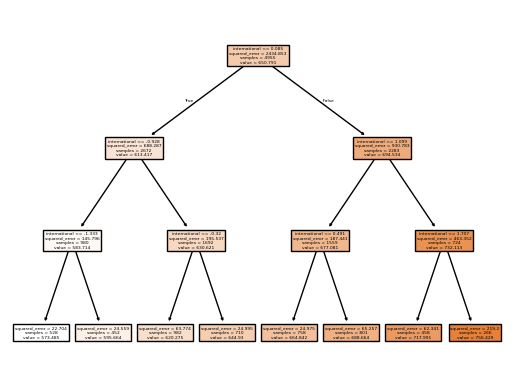

In [39]:

plot_tree(reg_pipeline.named_steps['clf'], filled=True, feature_names=X_train.columns)

[Text(0.375, 0.875, 'international <= -1.536\ngini = 0.942\nsamples = 4955\nvalue = [344.0, 184.0, 196.0, 256.0, 300.0, 355.0, 327.0, 360.0\n350.0, 391.0, 367.0, 322.0, 264.0, 215.0, 198.0, 154.0\n106.0, 81.0, 61.0, 48.0, 24.0, 52.0]'),
 Text(0.25, 0.625, 'gini = 0.0\nsamples = 344\nvalue = [344, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0\n0, 0, 0, 0, 0, 0, 0, 0]'),
 Text(0.3125, 0.75, 'True  '),
 Text(0.5, 0.625, 'international <= -0.117\ngini = 0.938\nsamples = 4611\nvalue = [0.0, 184.0, 196.0, 256.0, 300.0, 355.0, 327.0, 360.0\n350.0, 391.0, 367.0, 322.0, 264.0, 215.0, 198.0, 154.0\n106.0, 81.0, 61.0, 48.0, 24.0, 52.0]'),
 Text(0.4375, 0.75, '  False'),
 Text(0.25, 0.375, 'international <= -0.32\ngini = 0.849\nsamples = 1978\nvalue = [0, 184, 196, 256, 300, 355, 327, 360, 0, 0, 0, 0\n0, 0, 0, 0, 0, 0, 0, 0, 0, 0]'),
 Text(0.125, 0.125, 'gini = 0.824\nsamples = 1618\nvalue = [0.0, 184.0, 196.0, 256.0, 300.0, 355.0, 327.0, 0.0\n0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0\n0.0, 0.0, 0.

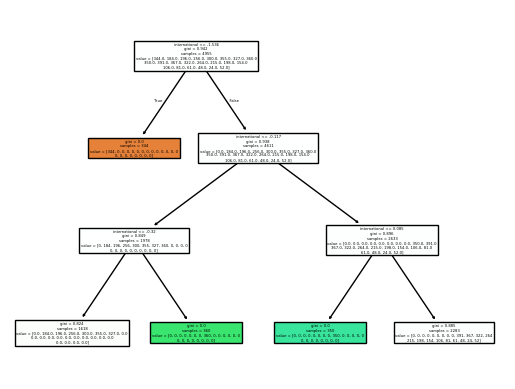

In [40]:
plot_tree(class_pipeline.named_steps['clf'], filled=True, feature_names=X_train.columns)